<a href="https://colab.research.google.com/github/Raspberry765/maching_learning/blob/main/local_outlier_factor_load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install umap-learn[plot]
! pip install umap-learn

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import umap.plot
#! pip uninstall umap
#Because I use this in colab, there some colab commands... sorry about that.
#!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from keras.models import Model
import umap
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
#from tensorflow.python.keras.models import load_model
from tensorflow import keras
#from tensorflow.keras.layers import load_model
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# L2レイヤーの定義

In [50]:
# Metric lerning（L2ノルム正則化）
"""
#If you don't need to learn alpha , you can choose below way too.
alpha = 30
def l2_constrain(x):
    return alpha * K.l2_normalize(x, axis=1)
model.add(layers.Lambda(l2_constrain))
"""

#This is custom layer way
# If you use trainable variables, you should write this way
# ref : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda#variables
class L2ConstrainLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(L2ConstrainLayer, self).__init__()
        self.alpha = tf.Variable(15.)

    def call(self, inputs):
        #about l2_normalize https://www.tensorflow.org/api_docs/python/tf/keras/backend/l2_normalize?hl=ja
        #print("call予備")
        return K.l2_normalize(inputs, axis=1) * self.alpha
    # def get_config(self):
    #     config = {'self': self.alpha}
    #     base_config = super(L2ConstrainLayer, self).get_config()
    #     return dict(list(base_config.items()) + list(config.items()))
    #     #return dict(list(base_config.items()) )

#機械学習モデルロード

In [51]:
load_model = load_model("/content/drive/MyDrive/aicop/Untitled Folder/model_weight-0019.h5",custom_objects={'L2ConstrainLayer':L2ConstrainLayer})
load_model.summary() #モデル情報を出力


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_32 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_10 (Flatten)        (None, 7744)              0         
                                                                 
 dense_19 (Dense)            (None, 64)                495680    
                                                     

# データセット用意

In [52]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = [train_images / 255.0, test_images / 255.0]

# 中間層の出力

In [55]:
#model = ...  # create the original model
layer_name = 'l2_constrain_layer_1' #エラーになった場合は上のmodelの層からsoftmaxの前の層の名前をとる。（l2_constrain_layer_？）になってたりする
intermediate_layer_model = Model(inputs=load_model.input,
                                 outputs=load_model.get_layer(layer_name).output)

# 学習の関数の定義

In [61]:
# 1回ずつエポックを実施する関数を定義
def train_2(model, X_train, y_train, epoch, batch,umap_model):

    acc = []
    val_acc = []
    loss = []
    val_loss = []

    for i in range(0,epoch, 1):
        # # パラメータ更新前の分布
        print(str(i),"実行中")
        print("エポック回数",str(epoch))
        hidden = intermediate_layer_model.predict(X_train)
        print("hidden",hidden[1,0:10])
        print("UMAP実行中")
        #hid_co = umap.UMAP(n_components=2, n_neighbors=40, verbose=1).fit(hidden)
        #umap_model = umap.UMAP(random_state=42)
        #hid_co = umap.UMAP().fit(hidden)
        hid_co = umap_model.fit(hidden)
        embedding_x = hid_co.embedding_[:, 0]
        embedding_y = hid_co.embedding_[:, 1]
        print("UMAP終了")
        plt.figure(figsize=(8,6))
        plt.xlim(-30,30) #x軸範囲指定
        plt.ylim(-30,30) #y軸範囲指定
        for nn in np.unique(y_train):
          plt.scatter(embedding_x[y_train == nn],
                    embedding_y[y_train == nn],
                    label=nn)
        #plt.colorbar()
        plt.legend()
        plt.title('Epoch  ' + str(i))
        plt.show()
        #plt.savefig('./fig/epoch_' + '{0:03d}'.format(i) + '.png', bbox_inches='tight')
        plt.close()
#        mapper = umap.UMAP().fit(hidden)
#        umap.plot.points(mapper, labels=y_train)
        # # 1epochだけ学習
        #history = model.fit(X_train, y_train, epochs=1, batch_size=batch, validation_split=0.2, verbose=1)
        
        # 重みをチェックポイントファイルへ出力
        #checkpoint_path = "result_CNN/checkpoint-{epoch:04d}.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)

        # 1エポックごとにモデルの重みを保存するコールバックを作成
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True,
        #period=1)

        # `checkpoint_path` フォーマットで重みを保存
        #model.save_weights(checkpoint_path.format(epoch=0))

        # checkpoint_path = "result_CNN/model_weight-{epoch:04d}.h5"
        # model.save(checkpoint_path.format(epoch=i))
        
        
        # # # 1epochだけ学習
        # history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch),
        #                       steps_per_epoch=len(X_train) / batch,
        #                       epochs=1,validation_data=(x_test, y_test),verbose=1)
        

        # # Lossなど保存
        # acc.append(history.history['accuracy'])
        # val_acc.append(history.history['val_accuracy'])
        # loss.append(history.history['loss'])
        # val_loss.append(history.history['val_loss'])
    return embedding_x,embedding_y

# trainデータのpredictの実行

0 実行中
エポック回数 2
1875/1875 [==============================] - 88s 47ms/step
hidden [2.3142662 0.        0.        0.        0.        8.213377  7.880844
 0.        0.        6.256928 ]
UMAP実行中
UMAP終了


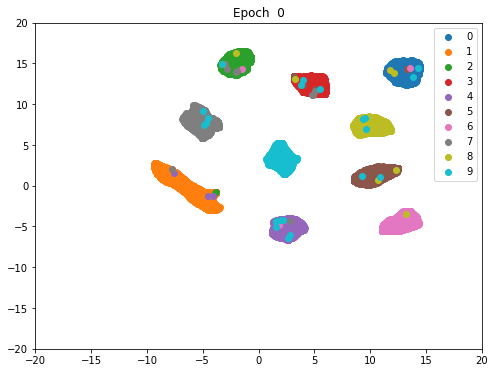

1 実行中
エポック回数 2
1875/1875 [==============================] - 88s 47ms/step
hidden [2.3142662 0.        0.        0.        0.        8.213377  7.880844
 0.        0.        6.256928 ]
UMAP実行中
UMAP終了


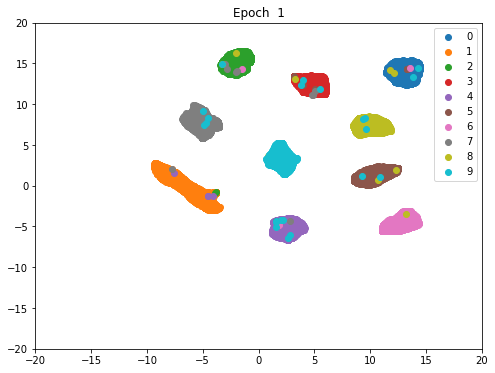

In [58]:
batch = 8
epoch = 2
umap_model_1 = umap.UMAP(random_state=42)
x_data_test,y_data_test=train_2(load_model,train_images, train_labels, epoch=2, batch=100,umap_model=umap_model_1)

# testデータのプレディクト

0 実行中
エポック回数 2
313/313 [==============================] - 18s 58ms/step
hidden [0.        0.        6.2871537 0.        0.        7.59058   0.
 0.        0.        0.       ]
UMAP実行中
UMAP終了


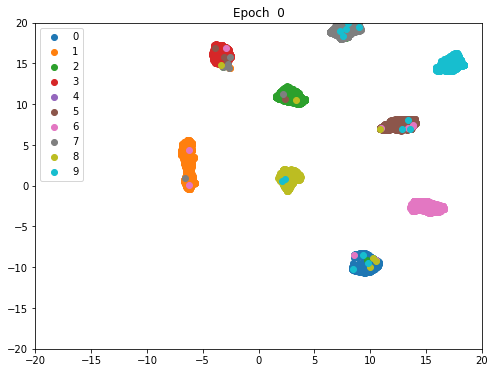

1 実行中
エポック回数 2
313/313 [==============================] - 14s 46ms/step
hidden [0.        0.        6.2871537 0.        0.        7.59058   0.
 0.        0.        0.       ]
UMAP実行中
UMAP終了


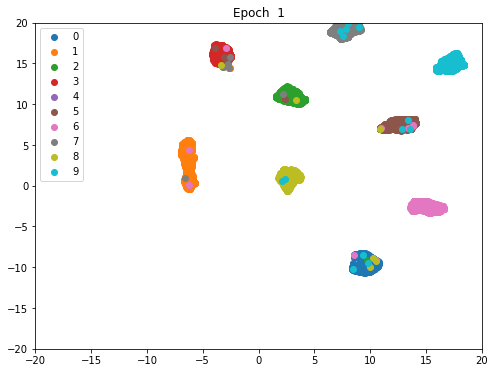

In [60]:
x_data,y_data=train_2(load_model,test_images, test_labels, epoch=2, batch=100,umap_model=umap_model_1)


# テストデータ作成とトレインデータのUMAPの値を取得


313/313 [==============================] - 14s 45ms/step


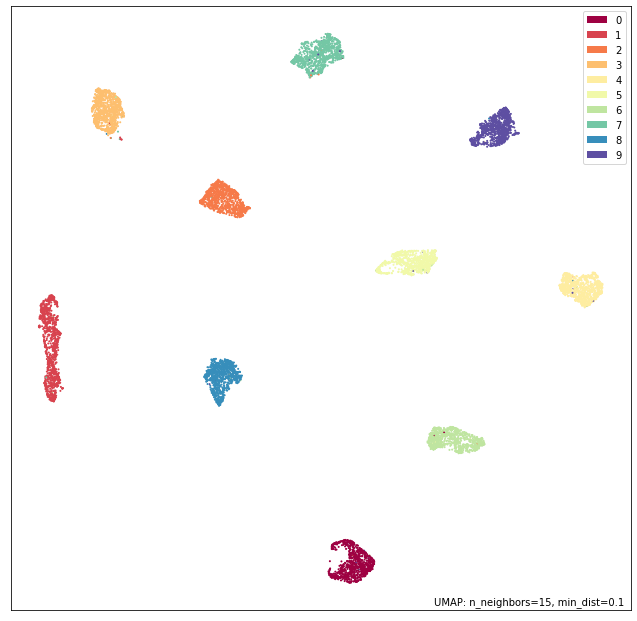

In [ ]:
#test dataのUMAP画像
hidden_test = intermediate_layer_model.predict(test_images)
umap_model = umap.UMAP(random_state=42)
#result=umap_model.fit_transform(hidden_test)
mapper_test =umap_model.fit(hidden_test)
umap.plot.points(mapper_test, labels=test_labels)
#x_data,y_data=train_2(load_model,test_images, test_labels, epoch=1, batch=100)

1875/1875 [==============================] - 13s 7ms/step


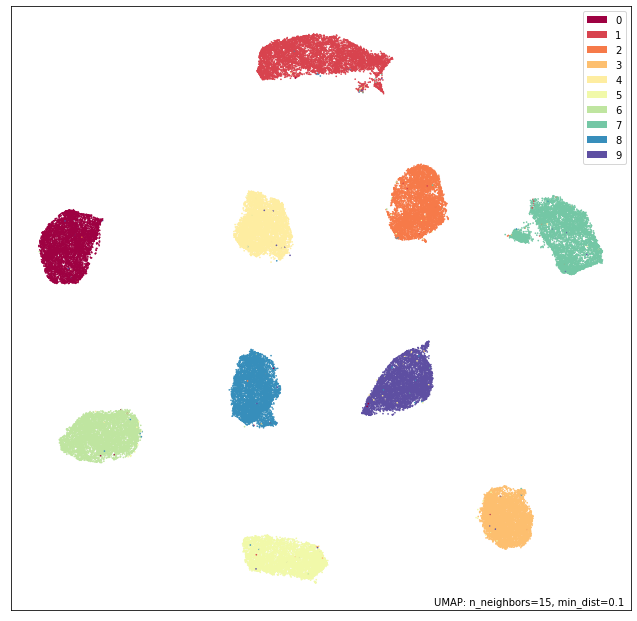

In [ ]:
#train dataのUMAP画像
hidden_train = intermediate_layer_model.predict(train_images)
mapper_train = umap.UMAP().fit(hidden_train)
umap.plot.points(mapper_train, labels=train_labels)


# print("UMAP実行中")
# #hid_co = umap.UMAP(n_components=2, n_neighbors=40, verbose=1).fit(hidden)
# hid_co = umap.UMAP().fit(hidden)
# embedding_x = hid_co.embedding_[:, 0]
# embedding_y = hid_co.embedding_[:, 1]
# print("UMAP終了")
# plt.figure(figsize=(8,6))
# plt.xlim(-20,20) #x軸範囲指定
# plt.ylim(-20,20) #y軸範囲指定
# for nn in np.unique(test_labels):
#   plt.scatter(embedding_x[test_labels == nn],
#             embedding_y[test_labels == nn],
#             label=nn)
# #plt.colorbar()
# plt.legend()
# plt.title('Epoch  ' + str(i))
# plt.show()

# 服データ

313/313 [==============================] - 2s 7ms/step


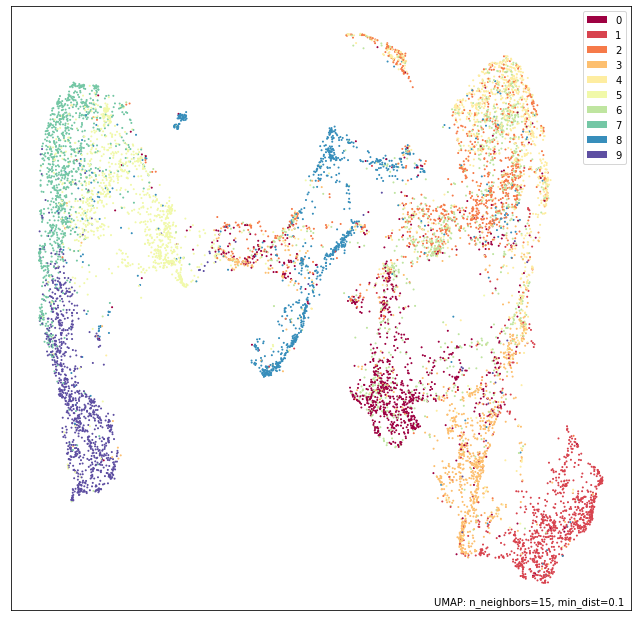

In [ ]:
from keras.datasets import fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
train_images_fashion = x_train_fashion.reshape((60000, 28, 28, 1))
test_images_fashion = x_test_fashion.reshape((10000, 28, 28, 1))

train_images_fashion, test_images_fashion = [train_images_fashion / 255.0, test_images_fashion / 255.0]

hidden_test_fashion = intermediate_layer_model.predict(test_images_fashion)

#hidden_train = intermediate_layer_model.predict(train_images)
#mapper_train = umap.UMAP().fit(hidden_train)
#umap.plot.points(mapper_train, labels=train_labels)
mapper_fashion = umap.UMAP().fit(hidden_test_fashion)
umap.plot.points(mapper_fashion, labels=y_test_fashion)

## 異常検知実装


1.   [参考サイト　Novelty detection with Local Outlier Factor](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_novelty_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-novelty-detection-py)

2.   [sclearnのLOF公式](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor.predict)
3.   [Qitta記事　Deep Metric Learning](https://qiita.com/jw-automation/items/7bbe1c872fcec7fa6c1d#local-outlier-factorlof) 
4.   [novelty=Trueである理由]Set novelty to True if you want to use LocalOutlierFactor for novelty detection.In this case be aware that you should only use predict, decision_function and score_samples 
on **new unseen data and not on the training set**; and note that the results obtained this way may differ from the standard LOF results.
5.   [clf.predict(X)] Returns -1 for anomalies/outliers and +1 for inliers.



In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.001,novelty=True)

clf.fit(mapper_train.embedding_)
y_pred_test_mnist_moji = clf.predict(mapper_test.embedding_) #new normal (not abnormal→文字データであるため) observations
n_error_test_mnist_moji = y_pred_test_mnist_moji[y_pred_test_mnist_moji == -1].size
y_pred_outliers = clf.predict(mapper_fashion.embedding_) #some abnormal (衣服のデータであるため) novel observations 
n_error_outliers  = y_pred_outliers[y_pred_outliers == -1].size
print("文字の異常値の数",n_error_test_mnist_moji )#何か違う気かする
print("服の異常値の数",n_error_outliers )#何か違う気かする

文字の異常値の数 8762
服の異常値の数 8011


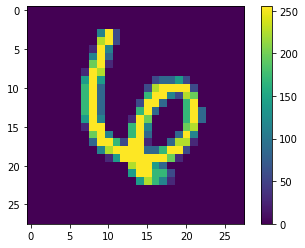

In [ ]:
#plotテスト
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
import matplotlib.pyplot as plt
index=22
plt.imshow(test_images[index])
plt.colorbar()

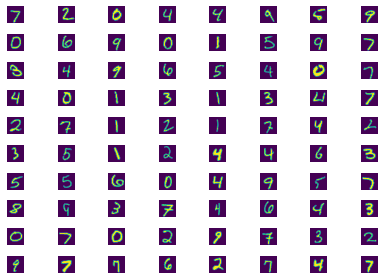

In [ ]:
index_num = np.array((range(0,10000,1)))
#len(index_num)

index_result = index_num[y_pred_test_mnist_moji == -1] 
#index_result
index_result[0]

nrows=10
ncols=8
 
# squeeze=Falseとしておけば、ncols=1でもaxes[i,j]と書ける
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, tight_layout=True)
ii=0
for i in range(nrows):
  for j in range(ncols):
    axes[i,j].imshow(test_images[ index_result[ii] ])
    axes[i,j].axis("off")
    #axes[i,j].set_title(f"plot({i}, {j})")
    ii = ii +1
 
plt.show()

#学習済みデータから異常検知を行う novelty_False

In [ ]:
clf_supervised_learning = LocalOutlierFactor(n_neighbors=20, contamination=0.001428,novelty=False)
outlier_scores_supervised_learning = clf_supervised_learning.fit_predict(mapper_train.embedding_)
a=outlier_scores_supervised_learning[outlier_scores_supervised_learning == -1]
print(a.size)
index_num = np.array((range(0,60000,1)))
#len(index_num)

index_result_supervised_learning = index_num[outlier_scores_supervised_learning == -1] 
index_result_supervised_learning

86


array([ 2326,  3030,  3322,  4502,  4955,  5013,  5103,  5129,  5548,
        5828,  7264,  7440,  8866, 11634, 11937, 12206, 12470, 14078,
       14152, 14305, 16302, 16488, 17543, 17772, 19460, 19702, 20402,
       20672, 20907, 22675, 25159, 25330, 27522, 27578, 29120, 30508,
       30990, 31264, 31341, 32413, 32510, 32636, 32896, 32908, 33340,
       33598, 33928, 34097, 34328, 35480, 36508, 37688, 38280, 38656,
       38728, 39341, 39672, 39708, 40700, 41295, 41475, 41509, 41882,
       42782, 42854, 45455, 45784, 47928, 47988, 49185, 49221, 49229,
       49910, 50202, 50734, 51102, 52218, 52456, 52886, 54943, 55452,
       55834, 55896, 57601, 58413, 58447])

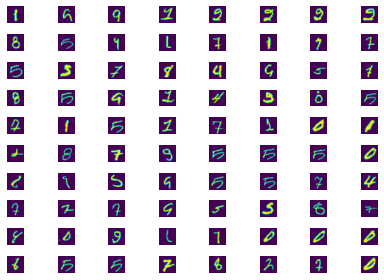

In [ ]:
nrows=10
ncols=8
 
# squeeze=Falseとしておけば、ncols=1でもaxes[i,j]と書ける
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, tight_layout=True)
ii=0
for i in range(nrows):
  for j in range(ncols):
    axes[i,j].imshow(train_images[ index_result_supervised_learning[ii] ])
    axes[i,j].axis("off")
    #axes[i,j].set_title(f"plot({i}, {j})")
    ii = ii +1
 
plt.show()